In [31]:
#import libraries and set the vectorBT portfolio settings

import numpy as np
import pandas as pd

np.random.seed(42)

In [32]:
import datetime as dt
# Tirei a CIEL3, pois ela não está mais sendo negociada

# ativos = pd.read_csv("./data/ativos_ibov/ativos.csv")['ativos'].to_list()
# ativos = [ativo + '.SA' for ativo in ativos]

indicadores = pd.read_csv('./data/indicadores/indicadores_final.csv', index_col='Data', parse_dates=True)['indicador']

# start = indicadores.index.min() - pd.Timedelta(365*2, 'days')
# end = indicadores.index.max()

# prices = yf.download(ativos, start=start, end=end)['Adj Close']
prices = pd.read_csv('./data/ativos_ibov/prices_adj_close.csv', index_col='Date', parse_dates=True)

prices = prices[prices.index <= dt.datetime(2023, 12, 30)]

In [33]:
limite_superior = 75
limite_inferior = 25

# Treino = Resto dos dados
# CV = 1 ano
# Teste = 1 ano

# K-fold = 2021, 2022, 2023

reotimizar = True

sinal = pd.Series(index=indicadores.index)
for data, indicador in indicadores.items():
    if (indicador > limite_superior or indicador < limite_inferior):
        if reotimizar:
            sinal.loc[data] = 1
        else:
            sinal.loc[data] = 0
        reotimizar = False
    else:
        sinal.loc[data] = 0
        reotimizar = True

indicadores_sinal = pd.concat([indicadores, sinal], axis=1)

In [34]:
# Alinhar os indicadores aos dias úteis dos preços
# Obtemos o índice (datas) do DataFrame de preços
prices_limite = prices[prices.index >= indicadores_sinal.index.min()]
business_days = prices_limite.index

# Reindexar o DataFrame de indicadores para usar apenas os dias úteis dos preços
indicadores_sinal = indicadores_sinal.reindex(business_days).ffill()

# Verificar se os índices estão agora alinhados
print(prices_limite.index.equals(indicadores_sinal.index)) # Deve retornar True se estiverem alinhados


True


In [35]:
import riskfolio as rp
import pandas as pd

# TODO: Constraints da otimização
# Restrições:
# - No max 25% em um ativo
# - Usar estudo do artigo

def optimization(prices, data):
    # Selecionando o período de 2 anos de dados
    grupo = prices[prices.index <= data].iloc[-252*2:]

    # Calculando os retornos
    Y = grupo.pct_change().dropna()

    # Criando o portfólio
    port = rp.Portfolio(returns=Y)

    method_mu = 'hist'
    method_cov = 'ledoit'  # hist, ledoit, ewma (suavização exponencial)

    # Calculando as estatísticas dos ativos
    port.assets_stats(method_mu=method_mu, method_cov=method_cov)

    # Parâmetros da otimização
    model = 'Classic'
    rm = 'MV'
    obj = 'MinRisk'
    hist = True
    rf = 0
    l = 0

    # Otimizando o portfólio
    return port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

prices.sort_index(inplace=True)
indicadores_limite = indicadores_sinal.loc[indicadores_sinal[0] == 1, 0]
indicadores_limite.sort_index(inplace=True)


pesos = pd.DataFrame()
for data, entry in indicadores_limite.items():
    if entry:
        w = optimization(prices, data).T
        w.index = [data]
        pesos = pd.concat([pesos, w], axis=0)

pesos

,ABEV3.SA,ALPA4.SA,BBAS3.SA,BBDC3.SA,BBDC4.SA,BEEF3.SA,BRAP4.SA,BRFS3.SA,BRKM5.SA,CCRO3.SA,...,TAEE11.SA,TIMS3.SA,TOTS3.SA,TRPL4.SA,UGPA3.SA,USIM5.SA,VALE3.SA,VIVT3.SA,WEGE3.SA,YDUQ3.SA
2015-08-07,9.402251e-03,5.369620e-03,9.543452e-10,9.318884e-10,1.044926e-09,6.436506e-09,3.958341e-09,1.041723e-02,1.083302e-03,1.516685e-09,...,0.018254,1.031611e-08,3.568228e-03,0.004270,5.138090e-09,2.758947e-09,7.961299e-09,1.013961e-02,3.545822e-02,3.923636e-09
2015-08-24,1.023942e-02,5.796098e-03,5.097098e-09,5.558427e-09,6.052018e-09,5.291666e-08,1.405686e-08,1.166633e-02,1.604743e-03,9.520286e-09,...,0.017568,5.199495e-08,2.271003e-03,0.004872,3.445506e-08,8.111615e-09,2.209649e-08,7.893029e-03,3.303802e-02,7.921424e-08
2015-09-02,1.031329e-02,4.704729e-03,5.016309e-10,5.457376e-10,5.824766e-10,4.040968e-09,1.138012e-09,1.215629e-02,2.647480e-03,9.296376e-10,...,0.016827,3.170809e-09,1.657398e-03,0.004166,2.757586e-09,8.171634e-10,1.386738e-09,7.082940e-03,3.223866e-02,1.897931e-08
2015-09-22,1.093866e-02,6.313835e-03,3.212465e-09,3.698271e-09,3.752724e-09,4.394183e-08,1.015948e-08,1.410225e-02,3.327835e-03,5.831697e-09,...,0.016068,2.659612e-08,1.651361e-03,0.004018,2.247479e-08,8.113560e-09,1.110454e-08,7.830996e-03,3.143604e-02,2.924343e-07
2015-09-25,1.108461e-02,5.586405e-03,1.271861e-09,1.478704e-09,1.504345e-09,1.556931e-08,3.709318e-09,1.493545e-02,3.755507e-03,2.307426e-09,...,0.016511,1.246116e-08,1.668632e-03,0.003553,8.640472e-09,2.672939e-09,4.049101e-09,7.126850e-03,3.062118e-02,3.998921e-05
2015-09-28,1.117308e-02,5.515225e-03,1.387705e-09,1.620538e-09,1.653001e-09,1.619186e-08,3.912524e-09,1.493014e-02,3.686140e-03,2.533342e-09,...,0.016863,1.244847e-08,1.596533e-03,0.003362,9.272543e-09,2.932584e-09,4.179807e-09,7.141262e-03,3.028556e-02,3.654335e-05
2015-12-16,4.221848e-03,7.034549e-05,5.022360e-10,8.818287e-10,7.970695e-10,2.734067e-09,1.366979e-09,1.984533e-02,3.914721e-03,1.638919e-09,...,0.027800,6.077280e-04,1.889327e-08,0.006254,3.543122e-09,1.239476e-03,1.749389e-09,1.541724e-02,2.397741e-02,7.767186e-09
2016-01-18,2.040368e-03,1.058087e-03,3.267903e-10,5.690308e-10,5.265071e-10,1.344988e-09,7.181803e-10,1.860607e-02,5.210743e-03,8.978305e-10,...,0.028279,1.714277e-03,7.107455e-09,0.005306,1.849030e-09,2.564695e-04,1.038507e-09,1.160432e-02,2.181010e-02,1.320441e-08
2016-02-11,3.175147e-04,4.040038e-03,1.879566e-10,3.561489e-10,3.066174e-10,8.492558e-10,3.459654e-10,1.803271e-02,5.555764e-03,4.242410e-10,...,0.025739,1.319392e-08,5.923226e-09,0.003732,1.061565e-09,9.892143e-04,5.137005e-10,1.033231e-02,1.853195e-02,1.330795e-09
2016-04-01,1.452784e-02,9.277663e-03,1.359518e-10,2.500153e-10,2.187750e-10,2.717353e-09,3.094879e-10,1.985304e-02,3.653007e-03,3.855509e-10,...,0.033383,8.266606e-09,8.404188e-09,0.006796,8.906318e-10,1.603978e-03,3.707470e-10,6.167121e-03,2.308629e-02,1.278138e-09


[*********************100%%**********************]  1 of 1 completed


100%|██████████| 3/3 [00:10<00:00,  3.38s/it]


<Axes: title={'center': 'Equity Progression'}>

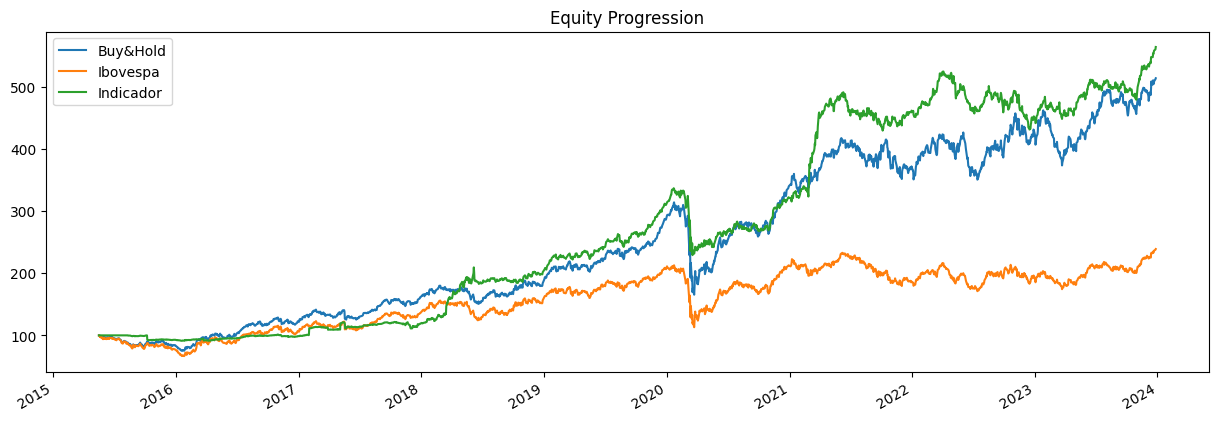

In [225]:
import bt
import yfinance as yf

prices = prices[prices.index >= indicadores.index.min()]

# Medir turnover (o quanto seus pesos mudam ao longo do tempo)

# Estratégia Buy and Hold
strat_buy_hold = bt.Strategy('Buy&Hold', [
    bt.algos.RunOnce(),
    bt.algos.SelectAll(),
    bt.algos.WeighEqually(),
    bt.algos.Rebalance()
])
# Ibovespa
ibov = yf.download('^BVSP', start=prices.index.min().strftime('%Y-%m-%d'), end=prices.index.max().strftime('%Y-%m-%d'))[['Adj Close']]

# Estratégia baseada no Ibovespa (exemplo simples de benchmark)
strat_ibov = bt.Strategy('Ibovespa', [
    bt.algos.RunOnce(),
    bt.algos.SelectAll(),
    bt.algos.WeighEqually(),
    bt.algos.Rebalance()
])

# Estratégia CVM trimestral
strat_cvm_trimestral = bt.Strategy('CVM Trimestral', [
    bt.algos.WeighTarget(pesos_trimestrais),
    bt.algos.Rebalance()
])


# Estratégia baseada no indicador
strat_indicador = bt.Strategy('Indicador CVM', [
    bt.algos.WeighTarget(pesos),
    bt.algos.Rebalance()
])
# Criando o backtest
backtests = [
    bt.Backtest(strat_cvm_trimestral, prices, initial_capital=1000000000),
    bt.Backtest(strat_ibov, ibov, initial_capital=1000000000),
    bt.Backtest(strat_indicador, prices, initial_capital=1000000000)
]

# Executando o backtest
results = bt.run(*backtests)

# Plotando os resultados
results.plot()

In [226]:
# Resultados
results.display()

Stat                 CVM Trimestral    Ibovespa    Indicador CVM
-------------------  ----------------  ----------  ---------------
Start                2015-05-17        2015-05-17  2015-05-17
End                  2023-12-27        2023-12-27  2023-12-27
Risk-free rate       0.00%             0.00%       0.00%

Total Return         413.27%     138.76%     463.52%
Daily Sharpe         0.92        0.54        1.20
Daily Sortino        1.41        0.84        1.99
CAGR                 20.91%      10.63%      22.23%
Max Drawdown         -47.30%     -46.82%     -31.94%
Calmar Ratio         0.44        0.23        0.70

MTD                  3.99%       5.39%       6.20%
3m                   8.33%       17.38%      14.88%
6m                   16.25%      14.19%      12.40%
YTD                  19.41%      21.96%      24.67%
1Y                   22.25%      23.86%      26.31%
3Y (ann.)            15.13%      4.08%       20.61%
5Y (ann.)            23.32%      9.45%       23.27%
10Y (ann.)    

In [227]:
trans = results.get_transactions('Indicador')

KeyError: 'Indicador'

In [228]:
import pandas as pd

opt = pd.read_csv('./data/resultados_otimization.csv')

opt.drop(columns=['Unnamed: 0'], inplace=True)

In [229]:
opt2 = opt[opt['obj'] == 'MinRisk'].reset_index(drop=True)
opt2.loc[np.argmax(opt2['total_return']), ['limite_inferior', 'limite_superior', 'obj', 'total_return']]

limite_inferior         21
limite_superior         76
obj                MinRisk
total_return       6.49831
Name: 67, dtype: object